In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader

from transformers import T5Tokenizer, T5EncoderModel
from transformers import AdamW

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# The model is called KE-T5 since it was trained with both Korean and Englihsh
# The vocabulary consists of 64,000 sub-word tokens
MODEL_NAME = 'KETI-AIR/ke-t5-large'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [4]:
from dataset.dataset import BaselineDataset
from dataset.preprocessor.preprocessors import BaselinePreprocessor, T5BasicPreprocessor

In [5]:
dataset = BaselineDataset(data_dir="/opt/ml/dataset/")
preprocessor = T5BasicPreprocessor()

dataset.set_tokenizer(tokenizer)
dataset.set_preprocessor(preprocessor)

In [6]:
dataset.preprocess()

In [7]:
for out in dataset:
    for key, value in out.items():
        print(key, value)
    break

input_ids tensor([10684, 16402, 35539,    73,    33,   305,  4679,  1120,    17,    10,
           33,   198,    76, 25112,  2974,    17,   103,     1, 13724, 27633,
          557,    91, 19150,    12, 15072, 25112,  2974,    15,  4299, 22345,
        32874, 24620,    48,  2366,  8278,   394, 10329,  3586,  4213,  7296,
            9,  2370,  2357,    66,     3,     1])
attention_mask tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label tensor(0)


In [8]:
for out in dataset:
    for key, value in out.items():
        print(value)
        print(tokenizer.decode(value))
        break
    break

tensor([10684, 16402, 35539,    73,    33,   305,  4679,  1120,    17,    10,
           33,   198,    76, 25112,  2974,    17,   103,     1, 13724, 27633,
          557,    91, 19150,    12, 15072, 25112,  2974,    15,  4299, 22345,
        32874, 24620,    48,  2366,  8278,   394, 10329,  3586,  4213,  7296,
            9,  2370,  2357,    66,     3,     1])
Guess relation from '비틀즈' to '조지 해리슨':</s> 〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.</s>


In [32]:
class CustomT5Classifier(nn.Module):
    def __init__(self, num_classes: int = 30, 
                 hidden_dims: int = 512,
                 num_layers:  int = 4,
                 dropout_p: float = 0.5,
                 use_hn:     bool = True,
                 model_name:  str = 'KETI-AIR/ke-t5-large'):

        super(CustomT5Classifier, self).__init__()

        self.num_classes = num_classes
        self.model_name  = model_name
        self.hidden_dims = hidden_dims
        self.num_gru_layers = num_layers
        self.dropout_p = dropout_p
        self.use_hn = use_hn
        
        self.t5  = T5EncoderModel.from_pretrained(model_name)
        self.gru = nn.GRU(input_size=1024, 
                          hidden_size=self.hidden_dims,
                          num_layers=self.num_gru_layers,
                          batch_first=True,
                          dropout=self.dropout_p,
                          bidirectional=True)

        self.fc = nn.Linear(2*self.hidden_dims, self.num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.t5.encoder(input_ids, attention_mask)
        out, h_n = self.gru(output['last_hidden_state'])
        if self.use_hn:
            output = F.gelu(out[:, -1, :].squeeze(1)) # last hidden states
        else:
            output = F.gelu(out[:, 0, :].squeeze(1))  # 
        output = F.gelu(out[:, -1, :].squeeze(1))
        output = self.fc(output)
        return output

In [33]:
model = CustomT5Classifier()
model.to(device)

Some weights of the model checkpoint at KETI-AIR/ke-t5-large were not used when initializing T5EncoderModel: ['decoder.block.4.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.22.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.17.layer.1.layer_norm.weight', 'decoder.block.2.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.19.layer.1.EncDecAttention.o.weight', 'decoder.block.19.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.19.layer.0.SelfAttention.q.weight', 'decoder.block.23.layer.1.layer_norm.weight', 'decoder.block.12.layer.1.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.10.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.3.layer.0.SelfAttention.q.weight', 'decoder.block.6.layer.1.EncDecAttention.v.weight', 'decoder.block.16.layer.1.EncDecAttention.q.weight', 'decoder.block.11.layer.1.layer_norm.weight', 'decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.5.

CustomT5Classifier(
  (t5): T5EncoderModel(
    (shared): Embedding(64128, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(64128, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedGeluDense(
                (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
                (wi_1): Line

In [20]:
model.eval()
with torch.no_grad():
    for inputs in dataset:
        
        input_ids = inputs['input_ids'].unsqueeze(0).to(device)
        attention_mask = inputs['attention_mask'].unsqueeze(0).to(device)
        labels = inputs['label'].to(device)

        print(input_ids.shape, attention_mask.shape, labels.shape)

        outputs = model(input_ids, attention_mask)
        print(outputs.shape)
            
        break

NameError: name 'dataset' is not defined

In [12]:
F.softmax(outputs, dim=-1)

tensor([[0.0318, 0.0351, 0.0333, 0.0335, 0.0336, 0.0339, 0.0320, 0.0328, 0.0335,
         0.0333, 0.0345, 0.0343, 0.0332, 0.0323, 0.0329, 0.0324, 0.0338, 0.0317,
         0.0341, 0.0333, 0.0335, 0.0337, 0.0340, 0.0325, 0.0331, 0.0335, 0.0332,
         0.0341, 0.0346, 0.0322]], device='cuda:0')

In [21]:
def collate_fn(samples):
    input_ids = [sample['input_ids'] for sample in samples]
    attention_mask = [sample['attention_mask'] for sample in samples]
    labels = [sample['label'] for sample in samples]

    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    return {'input_ids': input_ids.contiguous(),
            'attention_mask': attention_mask.contiguous(),
            'label': torch.stack(labels).contiguous()}

In [22]:
train_dataset = BaselineDataset(data_dir="/opt/ml/dataset/")
valid_dataset = BaselineDataset(data_dir="/opt/ml/dataset/")

train_dataset.data = train_dataset.data.iloc[:int(len(train_dataset)*0.8)].reset_index(drop=True)
valid_dataset.data = valid_dataset.data.iloc[int(len(valid_dataset)*0.8):].reset_index(drop=True)

preprocessor = T5BasicPreprocessor()

train_dataset.set_tokenizer(tokenizer)
train_dataset.set_preprocessor(preprocessor)

valid_dataset.set_tokenizer(tokenizer)
valid_dataset.set_preprocessor(preprocessor)

train_dataset.preprocess()
valid_dataset.preprocess()

In [37]:
BATCH_SIZE = 8
GRAD_UPDATE = 10

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [38]:
for idx, inputs in tqdm(enumerate(train_dataloader)):
        
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    labels = inputs['label']
    break

0it [00:00, ?it/s]


In [39]:
for idx, inputs in tqdm(enumerate(valid_dataloader)):
        
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    labels = inputs['label']
    break

0it [00:00, ?it/s]


In [40]:
# freeze all layers on t5
for idx, (name, param) in enumerate(model.named_parameters()):
    if name.startswith("gru") or name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [41]:
# unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [42]:
LEARNING_RATE = 3e-5

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=0.01,
                  correct_bias=False)

criterion = nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCHS = 10
LOG_EVERY  = 100
losses = []
val_losses = []

In [44]:
for epoch in range(NUM_EPOCHS):
    print("="*10, epoch, "epoch", "="*10)
    partial_loss = []

    model.train()
    for idx, inputs in tqdm(enumerate(train_dataloader)):
        
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = inputs['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        
        partial_loss.append(loss.item())

        if (idx+1) % LOG_EVERY == 0:
            cumulated_loss = np.mean(partial_loss)
            partial_loss = []
            losses.append(cumulated_loss)

        if (idx+1) % GRAD_UPDATE == 0:
            optimizer.step()
            optimizer.zero_grad()
    
    print("training loss:", np.mean(losses[-idx:]))

    val_partial_loss = []
    model.eval()
    with torch.no_grad():
        for idx, inputs in tqdm(enumerate(valid_dataloader)):
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = inputs['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_partial_loss.append(loss.item())

    cumulated_loss = np.mean(partial_loss)
    val_partial_loss = []
    val_losses.append(cumulated_loss)
    print("valid loss:", val_losses[-1])


0it [00:00, ?it/s]

========== 0 epoch ==========


3247it [13:26,  4.02it/s]
2it [00:00, 11.57it/s]

training loss: 1.2979499862901869


812it [01:08, 11.85it/s]
1it [00:00,  5.35it/s]

valid loss: 1.1836369316628639
========== 1 epoch ==========


3247it [13:27,  4.02it/s]
2it [00:00, 11.61it/s]

training loss: 1.2095181400631554


812it [01:08, 11.85it/s]
0it [00:00, ?it/s]

valid loss: 1.1136983848632651
========== 2 epoch ==========


849it [03:31,  4.02it/s]


KeyboardInterrupt: 

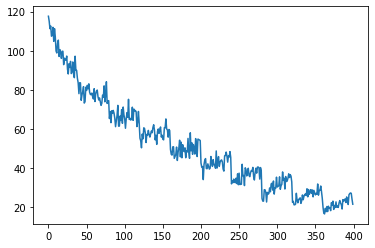

In [59]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [60]:
test_dataset = BaselineDataset(data_dir="/opt/ml/dataset/")

In [63]:
test_dataset.data = pd.read_csv(os.path.join(test_dataset.data_dir, test_dataset.test_file_name))

In [69]:
test_dataset.data["label"] = "no_relation"

In [70]:
test_dataset.set_preprocessor(preprocessor)
test_dataset.set_tokenizer(tokenizer)
test_dataset.preprocess()

In [78]:
BATCH_SIZE = 8

test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [122]:
import pickle as pickle

def num_to_label(label):
  """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
  """
  origin_label = []
  with open('/opt/ml/code/dict_num_to_label.pkl', 'rb') as f:
    dict_num_to_label = pickle.load(f)
  for v in label:
    origin_label.append(dict_num_to_label[v])
  return origin_label

In [126]:
output_pred = []
output_prob = []

model.eval()
with torch.no_grad():

    for idx, inputs in tqdm(enumerate(test_dataloader)):

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = inputs['label'].to(device)

        logits = model(input_ids, attention_mask)
        prob = F.softmax(logits, dim=-1).detach().cpu().numpy()

        answers = np.argmax(prob, axis=-1)

        output_pred.append(answers)
        output_prob.append(prob)

971it [00:59, 16.21it/s]


In [127]:
answers = np.concatenate(output_pred).tolist()
answers = num_to_label(answers)
probs   = np.concatenate(output_prob, axis=0).tolist()

In [128]:
answers

['org:alternate_names',
 'per:alternate_names',
 'no_relation',
 'no_relation',
 'org:top_members/employees',
 'no_relation',
 'per:employee_of',
 'per:spouse',
 'org:place_of_headquarters',
 'no_relation',
 'org:top_members/employees',
 'no_relation',
 'org:product',
 'no_relation',
 'no_relation',
 'no_relation',
 'per:alternate_names',
 'per:date_of_death',
 'no_relation',
 'no_relation',
 'no_relation',
 'org:top_members/employees',
 'no_relation',
 'per:employee_of',
 'no_relation',
 'org:place_of_headquarters',
 'per:title',
 'org:place_of_headquarters',
 'no_relation',
 'no_relation',
 'org:place_of_headquarters',
 'no_relation',
 'per:origin',
 'org:place_of_headquarters',
 'no_relation',
 'per:title',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'per:date_of_death',
 'per:title',
 'no_relation',
 'per:title',
 'org:top_members/employees',
 'no_relation',
 'org:product',
 'no_relation',
 'no_rel

In [129]:
probs

[[0.03282444551587105,
  0.00036398228257894516,
  1.8344298950978555e-05,
  0.10042967647314072,
  5.0987840950256214e-05,
  0.863523542881012,
  0.00020802074868697673,
  1.7116421076934785e-05,
  0.0016089436830952764,
  0.0001063477830030024,
  5.438792971546036e-09,
  1.7206893687671254e-07,
  4.8108129703905433e-05,
  6.338742863931657e-10,
  5.043037162977271e-06,
  5.1410946610985775e-08,
  1.153794726427293e-09,
  8.380933280704994e-08,
  3.532514892867766e-05,
  3.20568578899838e-05,
  0.0007232151692733169,
  1.6751798170844268e-08,
  9.17954423584888e-07,
  7.094845266841787e-10,
  1.2447081587652065e-07,
  1.4528420244630524e-08,
  1.8714697347377296e-08,
  7.657454115239659e-10,
  3.429014896028093e-06,
  2.8625365189327567e-08],
 [0.2361009120941162,
  3.6015782825415954e-05,
  5.811297887703404e-05,
  0.0017095927614718676,
  0.007150289602577686,
  0.05461002141237259,
  0.004049669019877911,
  0.0010357378050684929,
  0.0001748970680637285,
  1.889742270577699e-05,
  

In [132]:
output = pd.DataFrame({"id": list(range(0, len(answers))),
                       "sentence": test_dataset.data["sentence"],
                       "entity": test_dataset.data["concat_entity"],
                       "pred_label": answers,
                       "probs": probs})

output.to_csv("./submission.csv", index=False)

In [138]:
i =0
output.iloc[i*10:(i+1)*10, 1:4]

,sentence,entity,pred_label
0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,'MBC'[SEP] '탐사기획 스트레이트',org:alternate_names
1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,'프린세스 프링'[SEP] '공주',per:alternate_names
2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...",'경찰'[SEP] '1995년',no_relation
3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,'세조'[SEP] '정창손',no_relation
4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...",'민주당'[SEP] '권영진',org:top_members/employees
5,"미국은 필리핀 측에서는 동맹이 아니라 지배자가 되었다고 볼 수 있기 때문에, 필리핀...",'필리핀'[SEP] '미국',no_relation
6,"한국당 전희경 대변인은 이날 정 총리 후보자 지명 직후 논평을 내고 ""의회를 시녀화...",'전희경'[SEP] '한국당',per:employee_of
7,문재인 대통령 부인 김정숙 여사는 22일부터 1박2일 일정으로 광주를 방문해 경기를...,'문재인'[SEP] '김정숙',per:spouse
8,조선민주주의인민공화국 관할 지역은 개풍군 영북면 월고리 및 연천군 서남면 지역을 합...,'조선민주주의인민공화국'[SEP] '개풍군',org:place_of_headquarters
9,소련군에서 그의 이름도 중국식의 진지첸으로 조선인으로서의 정체성도 희박했다.,'소련군'[SEP] '진지첸',no_relation
